In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import matplotlib.pyplot as plt
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import harmonypy as hm

from matplotlib import rcParams
from pathlib import Path
from tqdm import tqdm

import iSp3D as MODEL
from iSp3D import Func
from iSp3D import iSpaNet
from iSp3D.Classifier import iSpaNetClassifier
from iSp3D.Utils import align_spatial_slices
from iSp3D.Attribution import compute_and_summary_by_cluster
from iSp3D.Metrics import compute_ARI, compute_NMI, compute_HOM, compute_COM, compute_PAS, compute_CHAOS
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.2'
os.environ['R_USER'] = r'C:\Users\CLEARLOVE\.conda\envs\STG\Lib\site-packages\rpy2'

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def get_data(config):
    count = pd.read_csv(
        r"C:\Code\Data\AMB\GSE147747_expr_raw_counts_table.tsv",
        sep="\t", index_col=0)

    meta = pd.read_csv(r"C:\Code\Data\AMB\GSE147747_meta_table.tsv",
                       sep="\t",
                       index_col=0)

    adata_st_all = ad.AnnData(X=count.values)
    adata_st_all.obs.index = count.index
    adata_st_all.obs = meta.loc[adata_st_all.obs.index]
    adata_st_all.var.index = count.columns

    slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
                 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
                 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
                 '31A', '32A', '33A', '34A', '35A',]

    result, mapping = mapping2int(slice_use)

    meta_slice = pd.read_csv(
        r"C:\Code\Data\AMB\data\figures\slicestable.tsv",
        index_col=0, sep="\t")
    slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
    slice_dist_micron = [-(slice_AP[i + 1] - slice_AP[i]) for i in range(len(slice_AP) - 1)]

    adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
    sc.pp.filter_cells(adata_st_all, min_genes=1)

    adata_st_all.obsm['spatial'] = np.concatenate(
        (adata_st_all.obs['HE_X'].values.reshape(-1, 1), adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

    for i, slice_id in enumerate(sorted(set(adata_st_all.obs.section_index.values))):
        adata_tmp = adata_st_all[adata_st_all.obs.section_index.values == slice_id]
        array_col = np.array([np.float32(loc.split("_")[1].split("x")[0]) for loc in adata_tmp.obs.index])
        if slice_id == '01A':
            array_col = array_col - 0.3
        array_row = np.array([np.float32(loc.split("_")[1].split("x")[1]) for loc in adata_tmp.obs.index])

        adata_tmp.obs['array_col'] = np.round(array_col)
        adata_tmp.obs['array_row'] = np.round(array_row)

        adata_tmp.obs['batch_name'] = slice_id
        adata_tmp.obs['slice_id'] = mapping[slice_id]

        adata_tmp.var_names_make_unique()
        # Remove mt-genes
        adata_tmp = adata_tmp[:, (np.array(~adata_tmp.var.index.str.startswith("mt-"))
                                  & np.array(~adata_tmp.var.index.str.startswith("MT-")))]
        adata_tmp.obs.index = adata_tmp.obs.index + "-slice%d" % i

        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['ABA_parent'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if i == 0:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = slice_id
            adata.obs['proj_name'] = slice_id
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = slice_id

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + slice_id
    adata.layers['count'] = adata.X
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata.obsm['X_original'] = adata.X.copy()

    pca = PCA(n_components=200, random_state=42)
    adata_X = pca.fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict, pca

def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI

In [ ]:
with open(r'C:\Code\iSpa3D\Config\Config_CMB.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [3]:
adata, graph_dict, pca = get_data(config['data'])

In [4]:
num_cluster = 15
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [5]:
net.train()

Epoch 495 total loss=3.565 recon loss=0.615 tri loss=0.000 disc loss=3.453 cluster loss=3.178:  50%|████▉     | 498/1000 [00:30<00:30, 16.45it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 545 total loss=3.006 recon loss=0.729 tri loss=0.632 disc loss=3.493 cluster loss=0.231:  55%|█████▍    | 549/1000 [01:26<00:47,  9.52it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=2.861 recon loss=0.651 tri loss=0.616 disc loss=3.473 cluster loss=0.073:  60%|██████    | 600/1000 [02:22<00:42,  9.48it/s]  

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=2.811 recon loss=0.646 tri loss=0.545 disc loss=3.473 cluster loss=0.056:  65%|██████▌   | 650/1000 [03:14<00:37,  9.29it/s]  

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=2.806 recon loss=0.638 tri loss=0.564 disc loss=3.465 cluster loss=0.046:  70%|██████▉   | 699/1000 [04:06<00:23, 12.84it/s]  

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=2.779 recon loss=0.627 tri loss=0.547 disc loss=3.453 cluster loss=0.042:  75%|███████▍  | 749/1000 [04:40<00:22, 11.12it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=2.767 recon loss=0.622 tri loss=0.537 disc loss=3.452 cluster loss=0.039:  80%|████████  | 800/1000 [05:14<00:19, 10.23it/s]

fitting ...
  |======================================================================| 100%


Epoch 845 total loss=2.734 recon loss=0.616 tri loss=0.498 disc loss=3.444 cluster loss=0.032:  85%|████████▍ | 849/1000 [06:03<00:12, 12.44it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=2.740 recon loss=0.615 tri loss=0.507 disc loss=3.448 cluster loss=0.033:  90%|████████▉ | 899/1000 [06:40<00:08, 11.46it/s]

fitting ...
  |======================================================================| 100%


Epoch 945 total loss=2.731 recon loss=0.613 tri loss=0.502 disc loss=3.442 cluster loss=0.029:  95%|█████████▌| 950/1000 [07:13<00:05,  9.71it/s]

fitting ...
  |======================================================================| 100%


Epoch 995 total loss=2.729 recon loss=0.607 tri loss=0.512 disc loss=3.441 cluster loss=0.027: 100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


In [6]:
def inverse_pca_transform(pca, recon_pca_data):
    recon_original = pca.inverse_transform(recon_pca_data)
    return recon_original

enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
recon_original = inverse_pca_transform(pca, recon)
adata.obsm['X_reconstructed'] = recon_original

print(adata)

AnnData object with n_obs × n_vars = 17086 × 3000
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'n_genes', 'array_col', 'array_row', 'batch_name', 'slice_id', 'proj_name', 'batch', 'Tmp_domain'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_original', 'X_pca', 'latent', 'recon', 'X_reconstructed'
    layers: 'count'


In [7]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


In [8]:
print(adata.obs['ABA_parent'].value_counts())

ABA_parent
Isocortex                  5734
Striatum                   1873
fiber tracts               1522
Hippocampal region         1307
Thalamus                   1281
Midbrain                   1235
Retrohippocampal region    1013
Olfactory areas            1000
Hypothalamus                765
Cortical subplate           410
Pallidum                    366
Hindbrain                   256
Undefined areas             178
ventricular systems         140
Cerebellum                    6
Name: count, dtype: int64


In [9]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
ARI = ari_score(sub_adata.obs['ABA_parent'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")

total ARI:0.45179655526145573


In [10]:
import matplotlib.pyplot as plt
from iSp3D.Classifier import iSpaNetClassifier
import os

with open('C:\\Code\\iSpa3D\\Config\\classifier_config.yaml', 'r', encoding='utf-8') as f:
    classifier_config = yaml.load(f.read(), Loader=yaml.FullLoader)
    
cluster_labels_original = adata.obs['mclust'].values.astype(int)
 
unique_labels = np.unique(cluster_labels_original)
label_mapping = {old: new for new, old in enumerate(sorted(unique_labels))}
cluster_labels_for_training = np.array([label_mapping[label] for label in cluster_labels_original])


classifier = iSpaNetClassifier(in_features=config['model']['latent_dim'], n_classes=len(unique_labels), config=classifier_config, device=device)
classifier.prepare_data(g3net_model=net, adata=adata, target_labels=cluster_labels_for_training)
classifier.train(epochs=classifier.max_epochs, verbose=True, early_stop_patience=50)

Epoch [ 10/300] Train Loss: 1.0091, Train Acc: 0.6872 | Val Loss: 0.7557, Val Acc: 0.7670
Epoch [ 20/300] Train Loss: 0.9727, Train Acc: 0.7033 | Val Loss: 0.7582, Val Acc: 0.7629
Epoch [ 30/300] Train Loss: 0.9791, Train Acc: 0.6970 | Val Loss: 0.8250, Val Acc: 0.7424
Epoch [ 40/300] Train Loss: 0.9666, Train Acc: 0.7030 | Val Loss: 0.7210, Val Acc: 0.7676
Epoch [ 50/300] Train Loss: 0.9617, Train Acc: 0.7046 | Val Loss: 0.7608, Val Acc: 0.7553
Epoch [ 60/300] Train Loss: 0.9601, Train Acc: 0.7035 | Val Loss: 0.7451, Val Acc: 0.7646
Epoch [ 70/300] Train Loss: 0.9598, Train Acc: 0.7054 | Val Loss: 0.7418, Val Acc: 0.7646
Epoch [ 80/300] Train Loss: 0.9640, Train Acc: 0.7024 | Val Loss: 0.7634, Val Acc: 0.7512
Epoch [ 90/300] Train Loss: 0.9875, Train Acc: 0.7026 | Val Loss: 0.7573, Val Acc: 0.7717
Epoch [100/300] Train Loss: 0.9796, Train Acc: 0.6985 | Val Loss: 0.7498, Val Acc: 0.7588

Early stopping at epoch 104


In [ ]:
from iSp3D.Attribution import compute_and_summary_by_cluster

res_df = compute_and_summary_by_cluster(
    net=net,
    cluster_key='mclust',  
    classifier=classifier,  # 传入训练好的分类器
    batch_size=64,
    top_k=100,
    pca=pca, 
    target_clusters=None,  # None表示对所有类别计算
    normalize= True,
    max_baselines=3,
    spatial_radius=2200
)

Computing attributions for 15 clusters...


Cluster attribution:   0%|          | 0/15 [00:00<?, ?it/s]

Cluster 1: neighbors = ['8', '7', '3']


Cluster attribution:   7%|▋         | 1/15 [01:03<14:52, 63.75s/it]

Cluster 10: neighbors = ['12', '6']


Cluster attribution:  13%|█▎        | 2/15 [01:43<10:44, 49.58s/it]

Cluster 11: neighbors = ['9']


Cluster attribution:  20%|██        | 3/15 [02:05<07:22, 36.85s/it]

Cluster 12: neighbors = ['10']


Cluster attribution:  27%|██▋       | 4/15 [02:27<05:41, 31.04s/it]

Cluster 13: neighbors = ['5']


Cluster attribution:  33%|███▎      | 5/15 [02:48<04:35, 27.57s/it]

Cluster 14: neighbors = ['1']


Cluster attribution:  40%|████      | 6/15 [03:10<03:50, 25.65s/it]

Cluster 15: neighbors = ['5', '3', '13']


Cluster attribution:  47%|████▋     | 7/15 [04:07<04:48, 36.01s/it]

Cluster 2: neighbors = ['11']


Cluster attribution:  53%|█████▎    | 8/15 [04:30<03:42, 31.83s/it]

Cluster 3: neighbors = ['15']


Cluster attribution:  60%|██████    | 9/15 [04:52<02:52, 28.81s/it]

Cluster 4: neighbors = ['7']


Cluster attribution:  67%|██████▋   | 10/15 [05:15<02:14, 26.89s/it]

Cluster 5: neighbors = ['15', '13']


Cluster attribution:  73%|███████▎  | 11/15 [05:55<02:03, 30.89s/it]

Cluster 6: neighbors = ['10', '8', '12']


Cluster attribution:  80%|████████  | 12/15 [06:58<02:01, 40.58s/it]

Cluster 7: neighbors = ['4']


Cluster attribution:  87%|████████▋ | 13/15 [07:21<01:10, 35.23s/it]

Cluster 8: neighbors = ['12', '1', '6']


Cluster attribution:  93%|█████████▎| 14/15 [08:19<00:42, 42.18s/it]

Cluster 9: neighbors = ['7', '12']


Cluster attribution: 100%|██████████| 15/15 [08:58<00:00, 35.92s/it]


In [ ]:
final_dfs, top_dict, per_method_dfs = res_df

for cluster_label in sorted(final_dfs.keys()):
    obj = final_dfs[cluster_label]
    
    if isinstance(obj, pd.DataFrame):
        sort_col = 'final_score' if 'final_score' in obj.columns else ('diff' if 'diff' in obj.columns else None)
        if sort_col:
            genes = obj.sort_values(sort_col, ascending=False).head(20).index.tolist()
        else:
            genes = obj.index[:20].tolist()
    else:
        genes = list(obj)[:20]
    
    print(f"Cluster {cluster_label}: {genes}")
    

Cluster 1: ['Tmsb4x', 'Wipf3', 'Pcdh20', 'Cnih2', 'Shisa6', 'Dsp', 'Crym', 'Gria1', 'St6galnac5', 'Spink8', 'Nr3c2', 'Prox1', 'Cabp7', 'Ppm1e', 'Tanc1', 'Iqgap2', 'Cpne6', 'Zeb2', 'Plppr4', 'Arpc5']
Cluster 10: ['Oxr1', 'Chgb', 'Ywhag', 'Syn2', 'Serinc1', 'Snap91', 'Serpini1', 'Nrsn1', 'Lmo4', 'Dclk1', 'Syt1', 'Dkk3', 'Pgm2l1', 'Dkkl1', 'Pfn2', 'Gfra2', 'Doc2a', 'Pclo', 'Slc39a10', 'Napb']
Cluster 11: ['Nap1l5', 'Zcchc12', 'Nrsn2', 'Ahi1', 'Ndn', 'Gap43', 'Sparc', 'Resp18', 'Gad2', 'Gprasp2', 'Slc6a11', 'Gaa', 'Rit2', 'Tac1', 'Impact', 'Tmem130', 'Scg2', 'Hap1', 'Slc32a1', 'Tmem91']
Cluster 12: ['Mbp', 'Plp1', 'Cldn11', 'Cnp', 'Mal', 'Mag', 'Tspan2', 'Cryab', 'Mobp', 'Mog', 'Sept4', 'Plekhb1', 'Gsn', 'Trf', 'Ugt8a', 'Qdpr', 'Pllp', 'Olig1', 'Opalin', 'Apod']
Cluster 13: ['Nrgn', 'Asb4', 'Gal', 'Nr4a2', 'X3110035E14Rik', 'Tbr1', 'Slc24a2', 'Atp2b1', 'Gm5741', 'Ttc9b', 'Pcp4', 'Itih3', 'Rgs4', 'Irs4', 'Adcy1', 'Arhgap36', 'Arpp19', 'Cck', 'Dlk1', 'Sytl2']
Cluster 14: ['Slc6a3', 'Slc18a2'

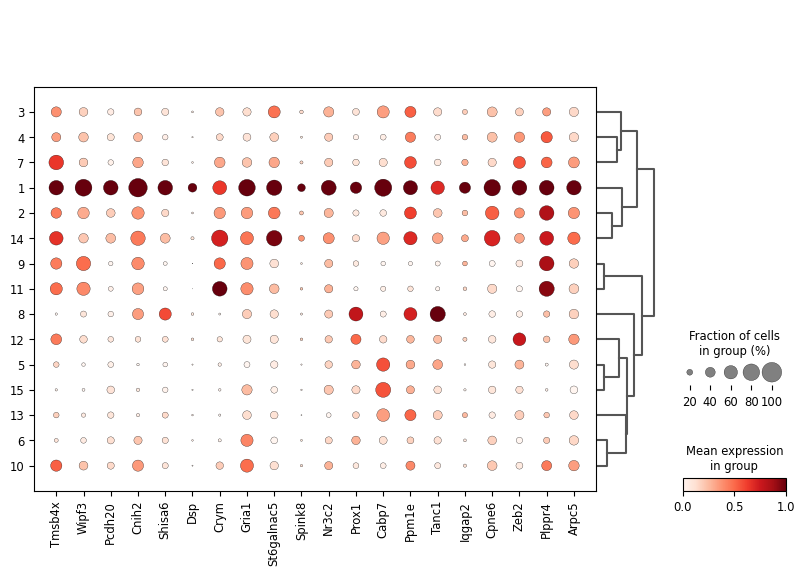

In [4]:
adata.obs['re_mclust'] = adata.obs['mclust'].astype(str)
dg = ['Tmsb4x', 'Wipf3', 'Pcdh20', 'Cnih2', 'Shisa6', 'Dsp', 'Crym', 'Gria1', 'St6galnac5', 'Spink8', 'Nr3c2', 'Prox1', 'Cabp7', 'Ppm1e', 'Tanc1', 'Iqgap2', 'Cpne6', 'Zeb2', 'Plppr4', 'Arpc5']
sc.pl.dotplot(adata, dg, groupby='re_mclust', dendrogram=True, swap_axes=False, standard_scale='var')